# Diagnosing and mitigatting BIAS in Word Embeddings

Based on the tutorial https://learn.responsibly.ai/word-embedding

Powered by [`responsibly`](https://docs.responsibly.ai/) - Toolkit for auditing and mitigating bias and fairness of machine learning systems 🔎🤖🧰

# Overview

We will be working on gender bias. In a nutshell we will: 
1. **Identify the gender sub-space**: we will be constructing a direction, or in a more general sense a **sub-space** in which we can distinguish the components of the gender bias. 

2. Hands on mitigation!

  2.1. **Neutralize**: given a *set of words that should be unbiased*, in our case gender neutral professions, this technique ensures that these words are in the middle of the previously identified subspace.

  2.2 **Equalize**: this technique works on *words* that should be neutral regarding to sets of words that represent a concept in different gender directions, for example {grandmother, grandfather}. After the equalization, the words that we consider should be neutral regarding gender (or the particular bias) will be equidistant to all the words of the set.

In all these techniques we refer to *sets of words* that are relevant to our bias analysis. These sets of words are a **key component** in all of the techniques we will be working on this workshop, and should be carefully ellaborated for each particular use case.


## Disclaimers

We focus on gender bias, and treat it as binary for the simplicity in this work. Nevertheless, gender is a complex social construct, and we should keep it in mind when we go back from a learning context to the real-world.

 # Setup

🛠️ Install `responsibly`

In [1]:
%pip install --user responsibly


**Restart** the Kernel/Runtime (use the menu on top or the botton in the notebook), **skip** the installation cell (`!pip install --user responsibly`) and **run** the cell below (`import responsibly`)

Validate Installation of `responsibly`
<big>🛠️</big>

In [2]:
import responsibly

# You should get '0.1.3'
responsibly.__version__

'0.1.3'

# Examples of Bias in Language Technology

There are many examples of the impact of bias
in language technology.
In [`this notebook`](https://colab.research.google.com/drive/1leU5YU_XYzq8Mcn5xqLivkRycorncxnW) we've collected a few.

# Word Embeddings

## How can we represent language in a machine understandable way?
It's clear that natural language is not machine interpretable, so 
we need some kind of *dictionary* 📖 to transform/encode

→ from a human representation (words) 🗣 🔡

→ to a machine representation (numbers) 🤖 🔢

A word embedding is a learned representation for text where words that have the same meaning have a similar representation.

To get a grasp on some basic embeddings properties, check [this notebook](https://colab.research.google.com/drive/1oCTFCSSkB08_ASWDkpsFYzjW3PvbI60b?usp=sharing)

# Diagnosing Gender Bias on Word Embeddings

To diagnose gender bias, we will be using techniques developed by Bolukbasi Tolga, Kai-Wei Chang, James Y. Zou, Venkatesh Saligrama, and Adam T. Kalai. [Man is to computer programmer as woman is to homemaker? debiasing word embeddings](https://arxiv.org/abs/1607.06520). NIPS 2016.

We will be diagnosing bias on [Word2Vec](https://code.google.com/archive/p/word2vec/) - Google News - 100B tokens, 3M vocab, cased, 300d vectors - only lowercase vocab extracted

Keep in mind, the data is from Google News, the writers are professional journalists.

### Key concept: vector analogies

One interesting property about word embeddings is that we can easily generate analogies. 

<img src="https://github.com/ResponsiblyAI/word-embedding/blob/main/images/linear-relationships.png?raw=1" />

<small>Source: [Tensorflow Documentation](https://www.tensorflow.org/tutorials/representation/word2vec)</small>

Loaded using [`responsibly`](http://docs.responsibly.ai) package, the function [`responsibly.we.load_w2v_small`]() returns a [`gensim`](https://radimrehurek.com/gensim/)'s [`KeyedVectors`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors) object.


In [3]:
from responsibly.we import load_w2v_small

w2v_small = load_w2v_small()

In [4]:
# man:king :: woman:?
# king - man + woman = ?

w2v_small.most_similar(positive=['king', 'woman'],
                       negative=['man'])

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236842632293701),
 ('queens', 0.5181134939193726),
 ('monarchy', 0.5087413191795349),
 ('throne', 0.5005807876586914),
 ('royal', 0.493820458650589),
 ('ruler', 0.49092739820480347)]

In [5]:
w2v_small.most_similar(positive=['big', 'smaller'],
                       negative=['small'])

[('bigger', 0.7836998105049133),
 ('larger', 0.5866795778274536),
 ('biggest', 0.5240509510040283),
 ('huge', 0.5084124207496643),
 ('sharper', 0.48242905735969543),
 ('heavier', 0.4784499406814575),
 ('tougher', 0.46322107315063477),
 ('better', 0.46317416429519653),
 ('major', 0.4562188386917114),
 ('quicker', 0.4514269232749939)]

## Think about a DIRECTION in word embedding as a RELATION

## $\overrightarrow{she} - \overrightarrow{he}$
## $\overrightarrow{smaller} - \overrightarrow{small}$
## $\overrightarrow{Spain} - \overrightarrow{Madrid}$


**Keep in mind that this direction is not a word vector by itself!**

In [6]:
# man:king :: woman:?
# king - man + woman = ?

w2v_small.most_similar(positive=['king', 'woman'],
                       negative=['man'])

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236842632293701),
 ('queens', 0.5181134939193726),
 ('monarchy', 0.5087413191795349),
 ('throne', 0.5005807876586914),
 ('royal', 0.493820458650589),
 ('ruler', 0.49092739820480347)]

In [7]:
w2v_small.most_similar(positive=['big', 'smaller'],
                       negative=['small'])

[('bigger', 0.7836998105049133),
 ('larger', 0.5866795778274536),
 ('biggest', 0.5240509510040283),
 ('huge', 0.5084124207496643),
 ('sharper', 0.48242905735969543),
 ('heavier', 0.4784499406814575),
 ('tougher', 0.46322107315063477),
 ('better', 0.46317416429519653),
 ('major', 0.4562188386917114),
 ('quicker', 0.4514269232749939)]

## Gender appropriate he-she analogies

In [8]:
# she:sister :: he:?
# sister - she + he = ?

w2v_small.most_similar(positive=['sister', 'he'],
                       negative=['she'])

[('brother', 0.7627110481262207),
 ('younger_brother', 0.6856132745742798),
 ('cousin', 0.6685015559196472),
 ('uncle', 0.6580697894096375),
 ('nephew', 0.65260249376297),
 ('father', 0.6411106586456299),
 ('son', 0.630827009677887),
 ('elder_brother', 0.585418701171875),
 ('brothers', 0.5706700086593628),
 ('twin_brother', 0.5622221231460571)]

```
queen-king
waitress-waiter
sister-brother
mother-father
ovarian_cancer-prostate_cancer
convent-monastery
```

## Gender stereotype he-she analogies

In [9]:
w2v_small.most_similar(positive=['nurse', 'he'],
                       negative=['she'])

[('doctor', 0.5559606552124023),
 ('medic', 0.5425378680229187),
 ('physician', 0.5394272208213806),
 ('surgeon', 0.5160146951675415),
 ('nurses', 0.49741458892822266),
 ('paramedic', 0.4924110770225525),
 ('patient', 0.46544164419174194),
 ('doctors', 0.4639861285686493),
 ('nursing', 0.46371760964393616),
 ('registered_nurse', 0.46238088607788086)]

```
sewing-carpentry
nurse-doctor
blond-burly
giggle-chuckle
sassy-snappy
volleyball-football
register_nurse-physician
interior_designer-architect
feminism-conservatism
vocalist-guitarist
diva-superstar
cupcakes-pizzas
housewife-shopkeeper
softball-baseball
cosmetics-pharmaceuticals
petite-lanky
charming-affable
hairdresser-barber
```

### Methodological Issue: The unrestricted version of analogy generation

It's important to take into consideration the fact that when generating an analogy, the method retrieves the most similar **different** word. 
So in the case of the very much used doctor - nurse analogy, we are specifically asking the model not to retrieve doctor. 

On top of that many recent studies show that the method of generating analogies enforce producing gender sterotype ones!

Nissim, M., van Noord, R., van der Goot, R. (2019). [Fair is Better than Sensational: Man is to Doctor as Woman is to Doctor](https://arxiv.org/abs/1905.09866).


In [10]:
# this method doesn't present the constraint that the most similar word
# is different from the provided ones
from responsibly.we import most_similar

In [11]:
most_similar(w2v_small,
             positive=['nurse', 'he'],
             negative=['she'])

[('nurse', 0.6655273495904702),
 ('doctor', 0.5559606137533434),
 ('medic', 0.5425378462972461),
 ('physician', 0.539427232345591),
 ('surgeon', 0.516014718645784),
 ('nurses', 0.49741458813916767),
 ('paramedic', 0.4924111160675495),
 ('patient', 0.46544163768108626),
 ('doctors', 0.46398611187975947),
 ('nursing', 0.4637176082334782)]

## What can we take from analogies? Gender Direction!

### $\overrightarrow{she} - \overrightarrow{he}$

In [12]:
from numpy.linalg import norm

gender_direction = w2v_small['she'] - w2v_small['he']

gender_direction /= norm(gender_direction)

In [13]:
# the @ operator returns the cosine similarity of 2 normalized vectors
gender_direction @ w2v_small['architect']

-0.16785555

In [14]:
gender_direction @ w2v_small['interior_designer']

0.19714224

**From this, we can interprete that the word *architect* appears in more contexts with *he* than with *she*, and vice versa for *interior designer*.**

In practice, we calculate the gender "direction" using multiple definitional pair of words for better estimation (words may have more than one meaning):

- woman - man
- girl - boy
- she - he
- mother - father
- daughter - son
- gal - guy
- female - male
- her - his
- herself - himself
- Mary - John

Note that this list of words is a very important input of the analysis.

### Try some words by yourself
In which way of the gender direction are our words located?


⚡ Keep in mind: You are performing exploratory data analysis, and not a systemic evaluation!

In [15]:
gender_direction @ w2v_small['house']

0.07210897

In [16]:
gender_direction @ w2v_small['home']

-0.016742865

## Projections in the gender direction

In [17]:
from responsibly.we import GenderBiasWE

w2v_small_gender_bias = GenderBiasWE(w2v_small, only_lower=True)

In [18]:
w2v_small_gender_bias.positive_end, w2v_small_gender_bias.negative_end

('she', 'he')

In [19]:
# gender direction
w2v_small_gender_bias.direction[:10]

array([-0.10056252, -0.09987912, -0.05384335,  0.00480521,  0.01521063,
       -0.01666582,  0.00932552, -0.00625998, -0.11320096,  0.03992424])

In [20]:
# list of gender neutral professions
from responsibly.we.data import BOLUKBASI_DATA

neutral_profession_names = BOLUKBASI_DATA['gender']['neutral_profession_names']

In [21]:
neutral_profession_names[:8]

['accountant',
 'acquaintance',
 'actor',
 'adjunct_professor',
 'administrator',
 'adventurer',
 'advocate',
 'aide']

Note: Why `actor` is in the neutral profession names list while `actress` is not there?
1. Due to the statistical nature of the method that is used to find the gender- specific and natural words
2. That might be because `actor` nowadays is much more gender-neutral, compared to waiter-waitress (see [Wikipedia - The term Actress](https://en.wikipedia.org/wiki/Actor#The_term_actress))

In [22]:
len(neutral_profession_names)

303

In [23]:
# the same of using the @ operator on the bias direction

w2v_small_gender_bias.project_on_direction(neutral_profession_names[0])

0.008421647916552755

**Let's visualize the projections of professions (neutral and specific by the orthography) on the gender direction**

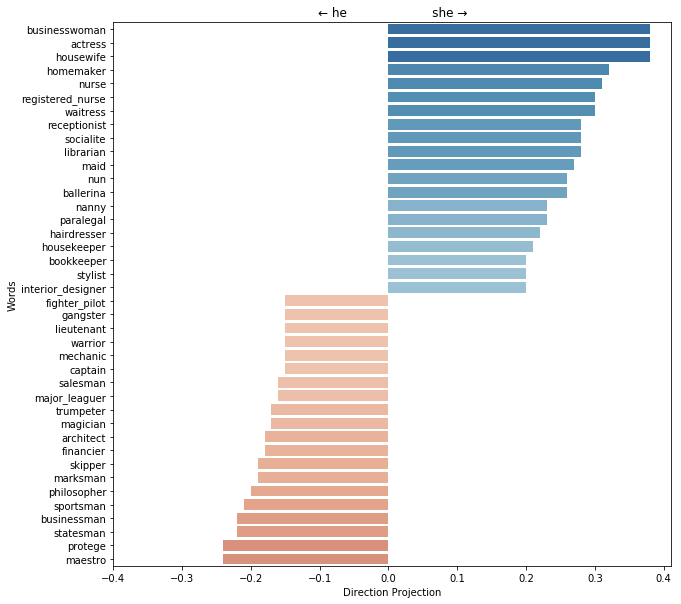

In [24]:
import matplotlib.pylab as plt

f, ax = plt.subplots(1, figsize=(10, 10))

w2v_small_gender_bias.plot_projection_scores(n_extreme=20, ax=ax);

EXTRA: Demo - Visualizing gender bias with [Word Clouds](http://wordbias.umiacs.umd.edu/)

### The projections of occupation words on the gender direction are related to the real world!

Let's take the percentage of female in various occupations from the Labor Force Statistics of 2017 Population Survey.

Taken from: https://arxiv.org/abs/1804.06876

Also: 
Garg, N., Schiebinger, L., Jurafsky, D., & Zou, J. (2018). [Word embeddings quantify 100 years of gender and ethnic stereotypes](https://www.pnas.org/content/pnas/115/16/E3635.full.pdf). Proceedings of the National Academy of Sciences, 115(16), E3635-E3644.


In [25]:
from operator import itemgetter  # 🛠️ For idiomatic sorting in Python

from responsibly.we.data import OCCUPATION_FEMALE_PRECENTAGE

sorted(OCCUPATION_FEMALE_PRECENTAGE.items(), key=itemgetter(1))

[('carpenter', 2),
 ('mechanician', 4),
 ('construction_worker', 4),
 ('laborer', 4),
 ('driver', 6),
 ('sheriff', 14),
 ('mover', 18),
 ('developer', 20),
 ('farmer', 22),
 ('guard', 22),
 ('chief', 27),
 ('janitor', 34),
 ('lawyer', 35),
 ('cook', 38),
 ('physician', 38),
 ('ceo', 39),
 ('analyst', 41),
 ('manager', 43),
 ('supervisor', 44),
 ('salesperson', 48),
 ('editor', 52),
 ('designers', 54),
 ('accountant', 61),
 ('auditor', 61),
 ('writer', 63),
 ('baker', 65),
 ('clerk', 72),
 ('cashier', 73),
 ('counselors', 73),
 ('attendant', 76),
 ('teacher', 78),
 ('sewer', 80),
 ('librarian', 84),
 ('assistant', 85),
 ('cleaner', 89),
 ('housekeeper', 89),
 ('nurse', 90),
 ('receptionist', 90),
 ('hairdressers', 92),
 ('secretary', 95)]

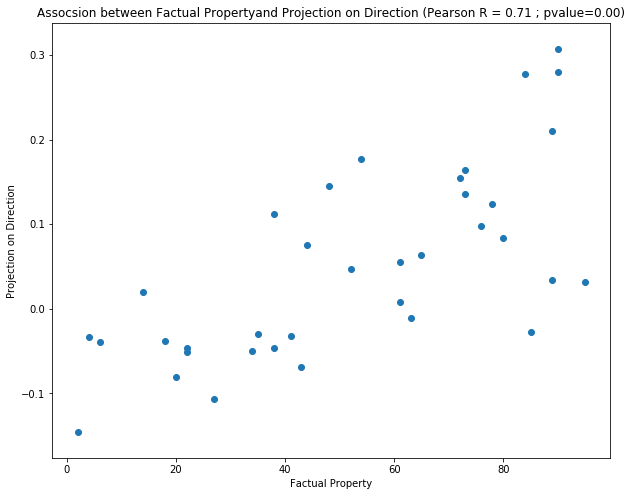

In [26]:
f, ax = plt.subplots(1, figsize=(10, 8))

w2v_small_gender_bias.plot_factual_association(ax=ax);

## Direct Bias Measure

1. Project each **neutral profession names** on the gender direction
2. Calculate the absolute value of each projection
3. Average it all

In [27]:
# using responsibly

w2v_small_gender_bias.calc_direct_bias()

0.07307905466893873

In [28]:
# what responsibly does:

neutral_profession_projections = [w2v_small[word] @ w2v_small_gender_bias.direction
                                  for word in neutral_profession_names]

abs_neutral_profession_projections = [abs(proj) for proj in neutral_profession_projections]

sum(abs_neutral_profession_projections) / len(abs_neutral_profession_projections)

0.0730790545759565

What are the assumptions of the direct bias measure? How the choice of neutral word effect on the definition of the bias? Can we measure **all** of the gender bias with this technique? 

An interesing thing of this method is that it gives us a quantitative measure of the bias present in the embedding, but keep in mind that this number only takes into consideration the bias present in the assumed neutral words.

What about words that are not in the list? Is this list comprehensive enough?

## Indirect Bias Measure

The direct bias analyzed above manifests in the relative similarities between gender-specific words and gender neutral words. Gender bias could also affect the relative geometry between gender
neutral words themselves. 

To test this indirect gender bias, as proposed by Bolukbasi et all, we take pairs of words that are gender-neutral, for example softball and football and project all the occupation words onto the softball − football direction.


For instance, the fact that the words bookkeeper
and receptionist are much closer to softball than football may result indirectly from female associations with bookkeeper, receptionist and softball. It’s important to point out that that many pairs of male-biased (or female-biased) words have legitimate associations having nothing to do with gender. For example footballer and football.

In [29]:
w2v_small_gender_bias.generate_closest_words_indirect_bias('softball',
                                                           'football')

projection  indirect_bias
end      word                                       
softball bookkeeper          0.178528       0.201158
         receptionist        0.158782       0.672343
         registered_nurse    0.156625       0.287150
         waitress            0.145104       0.317843
         paralegal           0.142549       0.372737
football cleric             -0.165978       0.017845
         maestro            -0.180458       0.415805
         pundit             -0.193207       0.101227
         businessman        -0.195981       0.170078
         footballer         -0.337857       0.015365

In [30]:
w2v_small_gender_bias.generate_closest_words_indirect_bias('math',
                                                           'art')

projection  indirect_bias
end  word                                         
math guidance_counselor    0.250974       0.004112
     teacher               0.247717       0.002339
     valedictorian         0.235697       0.009473
     tutor                 0.207957      -0.001194
     mathematician         0.196416      -0.028330
art  sculptor             -0.288942      -0.006383
     collector            -0.293837      -0.004053
     painter              -0.323438      -0.002841
     curator              -0.327560       0.003784
     artist               -0.383570       0.003042

# Hands on Mitigating Bias!

> We intentionally do not reference the resulting embeddings as "debiased" or free from all gender bias, and
prefer the term "mitigating bias" rather that "debiasing," to guard against the misconception that the resulting
embeddings are entirely "safe" and need not be critically evaluated for bias in downstream tasks. <small>James-Sorenson, H., & Alvarez-Melis, D. (2019). [Probabilistic Bias Mitigation in Word Embeddings](https://arxiv.org/pdf/1910.14497.pdf). arXiv preprint arXiv:1910.14497.</small>

## Neutralize

In this case, we will remove the gender projection from all the words, except the neutral-gender ones, and then normalize.

This method *needs* a list of gender neutral words to neutralize, or a list of words that are inherently gendered to not neutralize. 

Responsibly defines a list of neutral words and neutralizes those words.

In [31]:
w2v_small_gender_debias = w2v_small_gender_bias.debias(method='neutralize', inplace=False)

In [32]:
len(w2v_small.vocab)

26423

In [33]:
'home' in (w2v_small_gender_bias._data['neutral_words'])

True

In [34]:
print('home:',
      'before =', w2v_small_gender_bias.model['home'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['home'] @ w2v_small_gender_debias.direction)

home: before = 0.011340496779172263 after =  -1.176245451061858e-09


In [35]:
print('man:',
      'before =', w2v_small_gender_bias.model['man'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['man'] @ w2v_small_gender_debias.direction)

man: before = -0.22095192936041713 after =  -0.2209519293604172


In [36]:
print('woman:',
      'before =', w2v_small_gender_bias.model['woman'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['woman'] @ w2v_small_gender_debias.direction)

woman: before = 0.3403474745246814 after =  0.3403474745246813


In [37]:
w2v_small_gender_debias.calc_direct_bias()

1.1615064677713404e-09

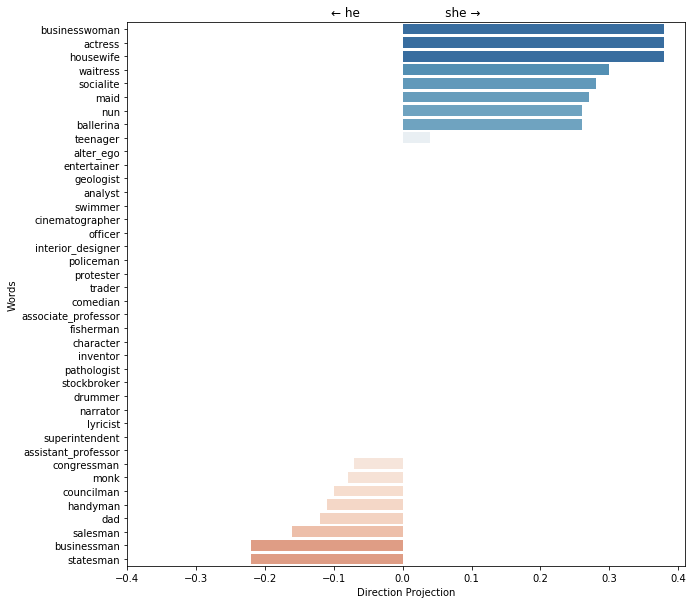

In [38]:
f, ax = plt.subplots(1, figsize=(10, 10))

w2v_small_gender_debias.plot_projection_scores(n_extreme=20, ax=ax);

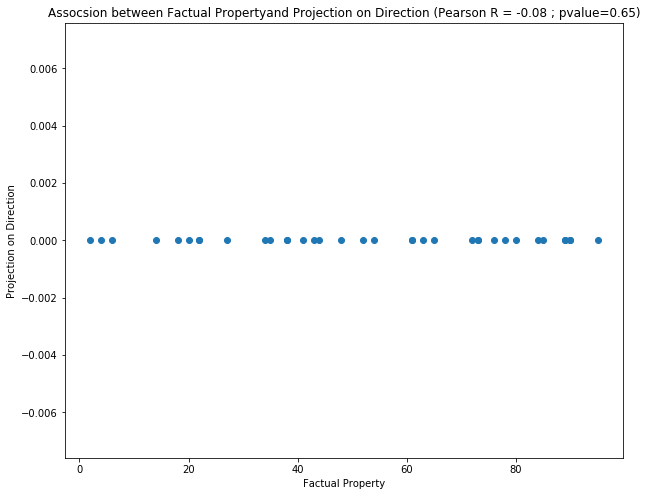

In [39]:
f, ax = plt.subplots(1, figsize=(10, 8))

w2v_small_gender_debias.plot_factual_association(ax=ax);

## Equalize

- Do you see that `man` and `woman` have a different projection on the gender direction? 

- It might cause to different similarity (distance) to neutral words, such as to `babysitter`

In [40]:
w2v_small_gender_debias.model['grandfather'] @ w2v_small_gender_debias.model['babysitter']

0.30331388

In [41]:
w2v_small_gender_debias.model['grandmother'] @ w2v_small_gender_debias.model['babysitter']

0.4470843

In [42]:
BOLUKBASI_DATA['gender']['equalize_pairs'][:10]

[['monastery', 'convent'],
 ['spokesman', 'spokeswoman'],
 ['Catholic_priest', 'nun'],
 ['Dad', 'Mom'],
 ['Men', 'Women'],
 ['councilman', 'councilwoman'],
 ['grandpa', 'grandma'],
 ['grandsons', 'granddaughters'],
 ['prostate_cancer', 'ovarian_cancer'],
 ['testosterone', 'estrogen']]

## Hard Debias = Neutralize + Equalize

In [43]:
w2v_small_gender_debias = w2v_small_gender_bias.debias(method='hard', inplace=False)

In [44]:
print('home:',
      'before =', w2v_small_gender_bias.model['home'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['home'] @ w2v_small_gender_debias.direction)

home: before = 0.011340496779172263 after =  -1.176245451061858e-09


In [45]:
print('man:',
      'before =', w2v_small_gender_bias.model['man'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['man'] @ w2v_small_gender_debias.direction)

man: before = -0.22095192936041713 after =  -0.34693385860531334


In [46]:
print('woman:',
      'before =', w2v_small_gender_bias.model['woman'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['woman'] @ w2v_small_gender_debias.direction)

woman: before = 0.3403474745246814 after =  0.34693386130538406


In [47]:
w2v_small_gender_debias.calc_direct_bias()

1.1780665108830956e-09

In [48]:
w2v_small_gender_debias.model['grandfather'] @ w2v_small_gender_debias.model['babysitter']

0.37519908

In [49]:
w2v_small_gender_debias.model['grandmother'] @ w2v_small_gender_debias.model['babysitter']

0.37519905

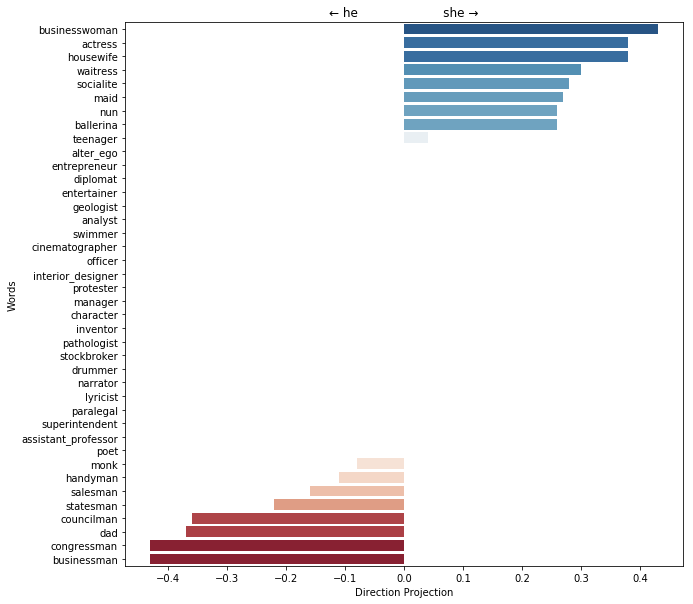

In [50]:
f, ax = plt.subplots(1, figsize=(10, 10))

w2v_small_gender_debias.plot_projection_scores(n_extreme=20, ax=ax);

The disadvantage of equalization is that it might remove meaningful association, such as the verb meaning of "grandfather", e.g. "to grandfather a regulation". Equalization removes this distinction.

### Compare Preformances

After debiasing, the performance of the word embedding, using standard benchmarks, get only slightly worse!

**⚠️ It might take few minutes to run!**

In [51]:
w2v_small_gender_bias.evaluate_word_embedding()

(           pearson_r  pearson_pvalue  ...  spearman_pvalue  ratio_unkonwn_words
 WS353          0.645           0.000  ...            0.000                9.915
 RG65           0.576           0.232  ...            0.321               14.286
 RW             0.611           0.000  ...            0.000               77.384
 Mturk          0.650           0.000  ...            0.000                1.558
 MEN            0.766           0.000  ...            0.000               15.148
 SimLex999      0.456           0.000  ...            0.000                1.702
 TR9856         0.666           0.000  ...            0.000               89.722
 
 [7 rows x 5 columns],             score
 MSR-syntax  0.750
 Google      0.729)

In [52]:
w2v_small_gender_debias.evaluate_word_embedding()

(           pearson_r  pearson_pvalue  ...  spearman_pvalue  ratio_unkonwn_words
 WS353          0.643           0.000  ...            0.000                9.915
 RG65           0.574           0.234  ...            0.321               14.286
 RW             0.611           0.000  ...            0.000               77.384
 Mturk          0.651           0.000  ...            0.000                1.558
 MEN            0.766           0.000  ...            0.000               15.148
 SimLex999      0.459           0.000  ...            0.000                1.702
 TR9856         0.665           0.000  ...            0.000               89.722
 
 [7 rows x 5 columns],             score
 MSR-syntax  0.751
 Google      0.726)

# So What?
We removed the gender bias, **as we defined it**, in a word embedding - 
Is there any impact on a downstream application?
In [this notebook](https://colab.research.google.com/drive/1_QpNw4aa2BduyFp1XcabB7f_u1limH6S?usp=sharing) you can find some examples of the impact of removing bias. 

In a nutshell, what we did: 

In [53]:
from responsibly.we import GenderBiasWE

w2v_small_gender_bias = GenderBiasWE(w2v_small, only_lower=True)

w2v_small_gender_debias = w2v_small_gender_bias.debias(method='neutralize', inplace=False)

In [54]:
w2v_small_gender_bias.calc_direct_bias()

0.07307905496967441

In [55]:
w2v_small_gender_debias.calc_direct_bias()

1.167572999942693e-09

# WEAT metric

Another metric worth mentioning is called **WEAT** (Word Embedding Association Test) which is inspired by **IAT** (Implicit-Association Test) from Pyschology.

Try IAT by yourself: https://implicit.harvard.edu/implicit/

**Caliskan, A., Bryson, J. J., & Narayanan, A. (2017). [Semantics derived automatically from language corpora contain human-like biases.](http://www.cs.bath.ac.uk/~jjb/ftp/CaliskanEtAl-authors-full.pdf) Science, 356(6334), 183-186.**


## Ingredients

1. Attribute words (e.g., Male ve. Female)

2. Target words (e.g., words related to Math vs. words related to Arts)

The null hypothesis is that there is no difference between the two sets of target words in terms of their relative similarity to the two sets of attribute words.

We are not going to include WEAT in this tutorial 
but in [this notebook](https://colab.research.google.com/drive/1EF54a6pKL1gu0SQtiyXt835y9Q_hBv12?usp=sharing) there is a tutorial using responsibly!  

# Your Turn!

In [61]:
from responsibly.we import load_w2v_small

w2v_small = load_w2v_small()

## Racial bias

Let's explor racial bias usint Tolga's approche. Will use the [`responsibly.we.BiasWordEmbedding`](http://docs.responsibly.ai/word-embedding-bias.html#ethically.we.bias.BiasWordEmbedding) class. `GenderBiasWE` is a sub-class of `BiasWordEmbedding`.

In [62]:
from responsibly.we import BiasWordEmbedding

w2v_small_racial_bias = BiasWordEmbedding(w2v_small, only_lower=True)

Identify the racial direction using the `sum` method

In [63]:
white_common_names = ['Emily', 'Anne', 'Jill', 'Allison', 'Laurie', 'Sarah', 'Meredith', 'Carrie',
                      'Kristen', 'Todd', 'Neil', 'Geoffrey', 'Brett', 'Brendan', 'Greg', 'Matthew',
                      'Jay', 'Brad']

black_common_names = ['Aisha', 'Keisha', 'Tamika', 'Lakisha', 'Tanisha', 'Latoya', 'Kenya', 'Latonya',
                      'Ebony', 'Rasheed', 'Tremayne', 'Kareem', 'Darnell', 'Tyrone', 'Hakim', 'Jamal',
                      'Leroy', 'Jermaine']

w2v_small_racial_bias._identify_direction('Whites', 'Blacks',
                                          definitional=(white_common_names, black_common_names),
                                          method='sum')

Use the neutral profession names to measure the racial bias

In [64]:
from responsibly.we.data import BOLUKBASI_DATA

neutral_profession_names = BOLUKBASI_DATA['gender']['neutral_profession_names']

In [65]:
neutral_profession_names[:10]

['accountant',
 'acquaintance',
 'actor',
 'adjunct_professor',
 'administrator',
 'adventurer',
 'advocate',
 'aide',
 'alderman',
 'alter_ego']

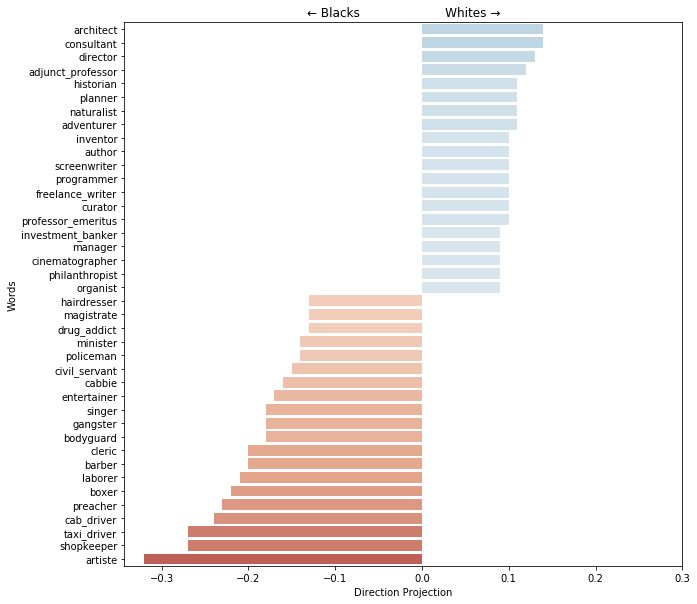

In [66]:
import matplotlib.pylab as plt

f, ax = plt.subplots(1, figsize=(10, 10))

w2v_small_racial_bias.plot_projection_scores(neutral_profession_names, n_extreme=20, ax=ax);

Calculate the direct bias measure

In [67]:
# Your Code Here...

Keep exploring the racial bias

In [68]:
# Your Code Here...

# Resources

## [Doing Data Science Responsibly - Resources](https://handbook.responsibly.ai/appendices/resources.html)

In particular:

- Timnit Gebru and Emily Denton - CVPR 2020 - [FATE Tutorial](https://youtu.be/-xGvcDzvi7Q) [Video]

- Rachel Thomas - fast.ai - [Algorithmic Bias (NLP video 16)](https://youtu.be/pThqge9QDn8) [Video]

- Solon Barocas, Moritz Hardt, Arvind Narayanan - [Fairness and machine learning - Limitations and Opportunities](https://fairmlbook.org/) [Textbook]

## [Course // Responsible AI, Law, Ethics & Society](https://learn.responsibly.ai/)

## [Course // Ethic aspects in AI (in spanish, from UBA)](https://campus.exactas.uba.ar/course/view.php?id=1477&section=0)


## Non-Technical Overview with More Downstream Application Examples
- [Google - Text Embedding Models Contain Bias. Here's Why That Matters.](https://developers.googleblog.com/2018/04/text-embedding-models-contain-bias.html)
- [Kai-Wei Chang (UCLA) - What It Takes to Control Societal Bias in Natural Language Processing](https://www.youtube.com/watch?v=RgcXD_1Cu18)
- Sun, T., Gaut, A., Tang, S., Huang, Y., ElSherief, M., Zhao, J., ... & Wang, W. Y. (2019). [Mitigating Gender Bias in Natural Language Processing: Literature Review](https://arxiv.org/pdf/1906.08976.pdf). arXiv preprint arXiv:1906.08976.

## Critical Prespective on Bias in NLP

Blodgett, S. L., Barocas, S., Daumé III, H., & Wallach, H. (2020). [Language (Technology) is Power: A Critical Survey of "Bias" in NLP](https://arxiv.org/pdf/2005.14050.pdf). arXiv preprint arXiv:2005.14050.

## Additional Related Work

- **Software Framework for Word Embedding Bias**
  - [WEFE: The Word Embeddings Fairness Evaluation Framework](https://wefe.readthedocs.io/en/latest/)

- **Understanding Bias**
    - Ethayarajh, K., Duvenaud, D., & Hirst, G. (2019, July). [Understanding Undesirable Word Embedding Associations](https://arxiv.org/pdf/1908.06361.pdf). In Proceedings of the 57th Annual Meeting of the Association for Computational Linguistics (pp. 1696-1705). - **Including critical analysis of the current metrics and debiasing methods (quite technical)**

  - Brunet, M. E., Alkalay-Houlihan, C., Anderson, A., & Zemel, R. (2019, May). [Understanding the Origins of Bias in Word Embeddings](https://arxiv.org/pdf/1810.03611.pdf). In International Conference on Machine Learning (pp. 803-811).

- **Discovering Bias**
  - Swinger, N., De-Arteaga, M., Heffernan IV, N. T., Leiserson, M. D., & Kalai, A. T. (2019, January). [What are the biases in my word embedding?](https://arxiv.org/pdf/1812.08769.pdf). In Proceedings of the 2019 AAAI/ACM Conference on AI, Ethics, and Society (pp. 305-311). ACM.
    Measuring Gender Bias in Word Embeddings across Domains and Discovering New Gender Bias Word Categories
  
  - Chaloner, K., & Maldonado, A. (2019, August). [Measuring Gender Bias in Word Embeddings across Domains and Discovering New Gender Bias Word Categories](https://www.aclweb.org/anthology/W19-3804). In Proceedings of the First Workshop on Gender Bias in Natural Language Processing (pp. 25-32).

- **Mitigating Bias**
  - Maudslay, R. H., Gonen, H., Cotterell, R., & Teufel, S. (2019). [It's All in the Name: Mitigating Gender Bias with Name-Based Counterfactual Data Substitution](https://arxiv.org/pdf/1909.00871.pdf). arXiv preprint arXiv:1909.00871.
  
  - Shin, S., Song, K., Jang, J., Kim, H., Joo, W., & Moon, I. C. (2020). [Neutralizing Gender Bias in Word Embedding with Latent Disentanglement and Counterfactual Generation](https://arxiv.org/pdf/2004.03133.pdf). arXiv preprint arXiv:2004.03133.
  
  - Zhang, B. H., Lemoine, B., & Mitchell, M. (2018, December). [Mitigating unwanted biases with adversarial learning](https://dl.acm.org/doi/pdf/10.1145/3278721.3278779?casa_token=yd1KGvVDBGwAAAAA:YzUT7d8Fq4bOV2b5M-CB43NLqIReW7wx2EaZj0omJ0ncbZF_pkPFoyV6WHWIBnG_HKIRqiG7FWFjsA). In Proceedings of the 2018 AAAI/ACM Conference on AI, Ethics, and Society (pp. 335-340). [Demo](https://colab.research.google.com/notebooks/ml_fairness/adversarial_debiasing.ipynb)
  
- **Fairness in Classification**
  - Prost, F., Thain, N., & Bolukbasi, T. (2019, August). [Debiasing Embeddings for Reduced Gender Bias in Text Classification](https://arxiv.org/pdf/1908.02810.pdf). In Proceedings of the First Workshop on Gender Bias in Natural Language Processing (pp. 69-75).
  
  - Romanov, A., De-Arteaga, M., Wallach, H., Chayes, J., Borgs, C., Chouldechova, A., ... & Kalai, A. (2019, June). [What's in a Name? Reducing Bias in Bios without Access to Protected Attributes](https://arxiv.org/pdf/1904.05233.pdf). In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers) (pp. 4187-4195).

- **Grammatical Gender**
  - Zhou, P., Shi, W., Zhao, J., Huang, K. H., Chen, M., & Chang, K. W. [Analyzing and Mitigating Gender Bias in Languages with Grammatical Gender and Bilingual Word Embeddings](https://aiforsocialgood.github.io/icml2019/accepted/track1/pdfs/47_aisg_icml2019.pdf). ICML 2019 - AI for Social Good. [Poster](https://aiforsocialgood.github.io/icml2019/accepted/track1/posters/47_aisg_icml2019.pdf)

  - Zhao, J., Mukherjee, S., Hosseini, S., Chang, K. W., & Awadallah, A. [Gender Bias in Multilingual Embeddings](https://www.researchgate.net/profile/Subhabrata_Mukherjee/publication/340660062_Gender_Bias_in_Multilingual_Embeddings/links/5e97428692851c2f52a6200a/Gender-Bias-in-Multilingual-Embeddings.pdf).

  - Gonen, H., Kementchedjhieva, Y., & Goldberg, Y. (2019). [How does Grammatical Gender Affect Noun Representations in Gender-Marking Languages?](https://arxiv.org/pdf/1910.14161.pdf). arXiv preprint arXiv:1910.14161.

- **Other**  
  - Zhao, J., Wang, T., Yatskar, M., Cotterell, R., Ordonez, V., & Chang, K. W. (2019, June). [Gender Bias in Contextualized Word Embeddings](https://arxiv.org/pdf/1904.03310.pdf). In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers) (pp. 629-634). [slides](https://jyzhao.net/files/naacl19.pdf)


##### Complete example of using `responsibly` with Word2Vec, GloVe and fastText: http://docs.responsibly.ai/notebooks/demo-gender-bias-words-embedding.html


## Bias in NLP

Around dozen of papers on this field until 2019, but nowdays plenty of work is done. Two venues from back then:
- [1st ACL Workshop on Gender Bias for Natural Language Processing](https://genderbiasnlp.talp.cat/)
- [NAACL 2019](https://naacl2019.org/)